<a href="https://colab.research.google.com/github/LeonimerMelo/CNNs/blob/main/CNN_for_CIFAR_10_Photo_Classification_1_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Tutorial

## Convolutional Neural Networks - part #1

---

In this notebook, we train a CNN to classify images from the CIFAR-10 database.

##CIFAR-10 Photo Classification Dataset

CIFAR is an acronym that stands for the [Canadian Institute For Advanced Research](https://www.cs.toronto.edu/~kriz/cifar.html) and the [CIFAR-10 dataset](https://en.wikipedia.org/wiki/CIFAR-10) was developed along with the CIFAR-100 dataset by researchers at the CIFAR institute.

The dataset is comprised of 60,000 32×32 pixel color photographs of objects from 10 classes, such as frogs, birds, cats, ships, etc. The class labels and their standard associated integer values are listed below.

    0: airplane
    1: automobile
    2: bird
    3: cat
    4: deer
    5: dog
    6: frog
    7: horse
    8: ship
    9: truck

These are very small images, much smaller than a typical photograph, and the dataset was intended for computer vision research.


<img src="https://miro.medium.com/v2/resize:fit:640/0*Paq_u6D7cHkALCDM" alt="perceptron" width=600>

In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, Input, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam, Adagrad, RMSprop, Adadelta
import time
from keras.models import model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

###Functions

In [ ]:
# função para calcular o tempo de treinamento da rede
def processing_time(start_t, finish_t):
  a = finish_t - start_t
  if a < 0:
    print('Error! time negative!')
    return
  hora = 0
  min = a // 60
  seg = a % 60
  if min > 59:
    hora = min // 60
    min = min % 60
  if hora > 0:
    print("\nElapsed time:%ih%im%is"% (hora, min, seg))
  else:
    print("\nElapsed time:%im%is"% (min, seg))

# função para plotar os gráficos da acurária e perda
def plot_acc_loss(h):
  plt.figure(figsize = (11,5))
  plt.subplot(1,2,1)
  plt.plot(h.history['loss'], label = 'Treino')
  plt.plot(h.history['val_loss'], label = 'Validação')
  plt.xlabel('Épocas')
  plt.ylabel('Função Custo')
  plt.title('loss')
  plt.xticks()
  plt.yticks()
  plt.legend()
  plt.grid()
  plt.subplot(1,2,2)
  plt.plot(h.history['accuracy'], label = 'Treino')
  plt.plot(h.history['val_accuracy'], label = 'Validação')
  plt.xlabel('Épocas')
  plt.ylabel('Acurácia')
  plt.title('accuracy')
  plt.xticks()
  plt.yticks()
  plt.legend()
  plt.tight_layout()
  plt.grid()
  plt.show()

path_models = '/content/drive/MyDrive/Colab Notebooks/models/'
# função para salvar o modelo da rede treinada (modelo, pesos e bias) e o 'history' que contem os vetores accuracy e loss
# para predições futuras sem ter que treiná-lo novamente
def save_model(model_, model_nr, hist):
  model_json = model_.to_json()
  with open(path_models + 'modelCNN_' + str(model_nr) + '.json','w') as json_file:
      json_file.write(model_json)
  model_.save_weights(path_models + 'weightsCNN_' + str(model_nr) + '.weights.h5')
  np.save(path_models + 'history_' + str(model_nr) + '.npy', hist)
  print('Saved model to disk')

# função para carregar o modelo da rede e os pesos já treinados previamente
# e o 'history' que contem os vetores accuracy e loss
def load_model(model_nr):
  # Load json and create model
  j_file = open(path_models + 'modelCNN_' + str(model_nr) + '.json','r')
  load_model_json = j_file.read()
  j_file.close()
  loaded_model=model_from_json(load_model_json)
  # Load weights into new model
  loaded_model.load_weights(path_models + 'weightsCNN_' + str(model_nr) + '.weights.h5')
  hist = np.load(path_models + 'history_' + str(model_nr) + '.npy', allow_pickle='TRUE').item()
  print('Loaded model from disk')
  return loaded_model, hist

### Carregando o banco de dados CIFAR-10

In [ ]:
# load the pre-shuffled train and test data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# rescale [0,255] --> [0,1]
X_train, X_test = X_train / 255.0, X_test / 255.0
# one hot encoding
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


We can see that there are 50,000 examples in the training dataset and 10,000 in the test dataset and that images are indeed square with 32×32 pixels and color, with three channels.

In [ ]:
# print shape of dataset
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train:',y_train.shape)
print('y_test:',y_test.shape)

X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
y_train: (50000, 1)
y_test: (10000, 1)


In [ ]:
# verificando as 10 classes com seus rótulos
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


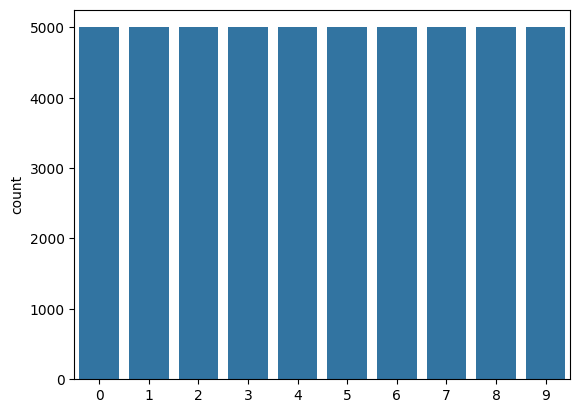

In [ ]:
# verificando a quantidade de amostras por classe
import seaborn as sns
g = sns.countplot(x=np.reshape(y_train,-1))

A plot of random images in the dataset is also created. It is clear that the images are indeed very small compared to modern photographs; it can be challenging to see what exactly is represented in some of the images given the extremely low resolution.

This low resolution is likely the cause of the limited performance that top-of-the-line algorithms are able to achieve on the dataset.

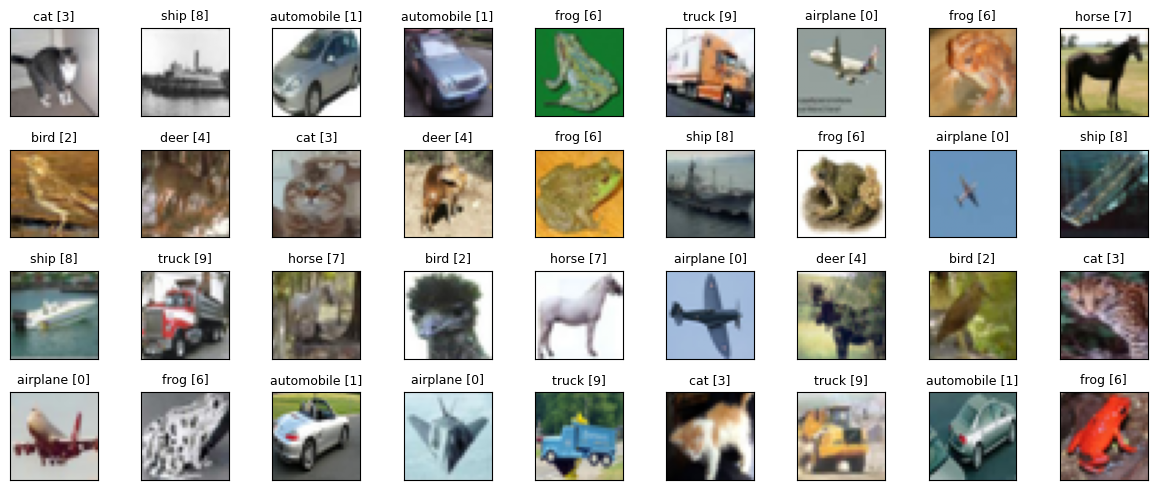

In [ ]:
# Visualize random Training Images
# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
j = np.random.randint(len(X_train)-36)
fig = plt.figure(figsize=(12,5))
for i in range(36):
  ax = fig.add_subplot(4, 9, i + 1, xticks=[], yticks=[])
  ax.imshow(X_train[i+j])
  ax.set_title("{} {}".format(cifar10_labels[y_train[i+j][0]], str(y_train[i+j])), size=9)
plt.tight_layout()
plt.show()

## Convolutional and pooling layers

convolutional and pooling layers to process an image and extract meaningful features that are specific to the images in the training dataset. To summarize how we got here:

1. The raw image is fed to the convolutional layer, which is a set of kernel filters
that slide over the image to extract features.
2. The convolutional layer has the following attributes that we need to configure:
```
from keras.layers import Conv2D
model.add(Conv2D(filters=16, kernel_size=2, strides='1',
padding='same', activation='relu'))
```
* `filters` is the number of kernel filters in each layer (the depth of the hidden layer).
* `kernel_size` is the size of the filter (aka kernel). Usually 2, or 3, or 5.
* `strides` is the amount by which the filter slides over the image. A strides
value of 1 or 2 is usually recommended as a good start.
* `padding` adds columns and rows of zero values around the border of the
image to reserve the image size in the next layer.
* `activation` of `relu` is strongly recommended in the hidden layers.

3. The pooling layer has the following attributes that we need to configure:
```
from keras.layers importMaxPooling2D
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
```


## Visualize what happens after each layer

After the convolutional layers, the image keeps its width and height dimensions (usually), but it gets deeper and deeper after each layer. Why? Remember the cutting-theimage-into-pieces-of-features analogy we mentioned earlier? That is what’s happening after the convolutional layer.

For example, suppose the input image is 28 × 28 (like in the MNIST dataset). When we add a CONV_1 layer (with filters of 4, strides of 1, and padding of same), the
output will be the same width and height dimensions but with depthof 4 (28 × 28 ×
4). Now we add a CONV_2 layer with the same hyperparameters but more filters (12),
and we get deeper output: 28 × 28 × 12.

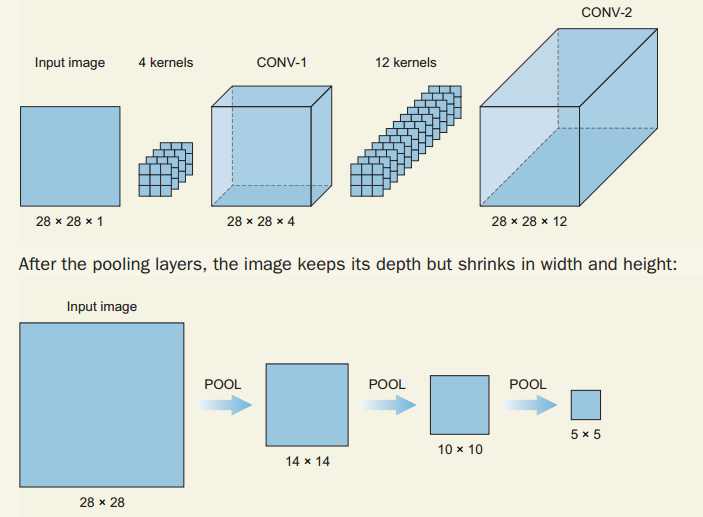

Putting the convolutional and pooling together, we get something like this:

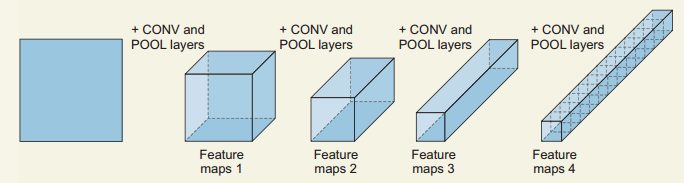

This keeps happening until we have, at the end, a long tube of small shaped images
that contain all the features in the original image.
The output of the convolutional and pooling layers produces a feature tube (5 × 5 ×
40) that is almostready to be classified. We use 40 here as an example for the depth
of the feature tube, as in 40 feature maps. The last step is to flatten this tube before
feeding it to the fully connected layer for classification. As discussed earlier, the flattened layer will have the dimensions of (1, m) where m = 5 × 5 × 40 = 1000 neurons.

## Fully connected layers

After passing the image through the feature-learning process using convolutional and
pooling layers, we have extracted all the features and put them in a long tube. Now it
is time to use these extracted features to classify images. We will use the regular neural
network architecture, MLP, that we discussed before.

### Why use fully connected layers?

MLPs work great in classification problems. The reason we used convolutional layers
in this chapter is that MLPs lose a lot of valuable information when extracting features
from  an  image—we  have  to  flatten  the  image  before  feeding  it  to  the  network—
whereas  convolutional  layers  can  process  raw  images.  Now  we  have  the  features
extracted, and after we flatten them, we can use regular MLPs to classify them.

We discussed the MLP architecture thoroughly berfore: nothing new here. To
reiterate, here are the fully connected layers:

* **Input flattened vector**—As illustrated in figure, to feed the features tube to
the MLP for classification, we flatten it to a vector with the dimensions (1, n).
For example, if the features tube has the dimensions of 5 × 5 × 40, the flattened
vector will be (1, 1000).
* **Hidden layer**—We add one or more fully connected layers, and each layer has
one or more neurons (similar to what we did when we built regular MLPs).
* **Output layer**—it's recommended using the softmax activation function for
classification problems involving more than two classes. In this example, we are
classifying digits from 0 to 9: 10 classes. The number of neurons in the output
layer is equal to the number of classes; thus, the output layer will have 10 nodes.

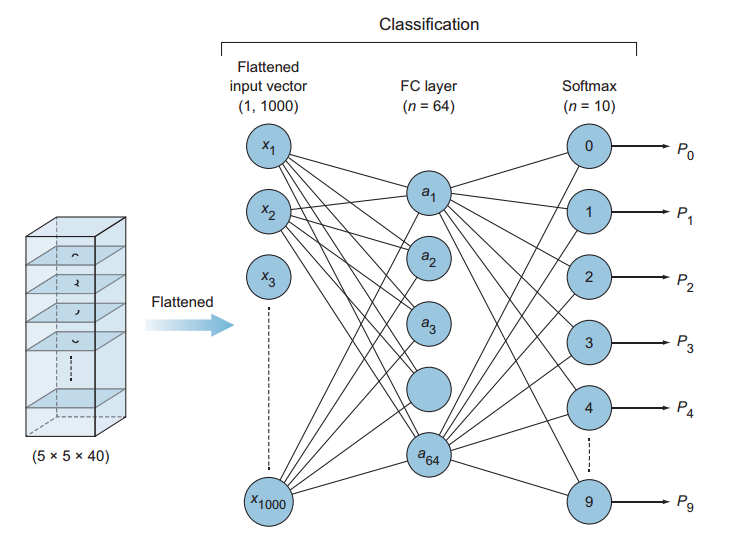

### Define the Model Architecture


##VGGNet
VGG stands for *Visual Geometry Group*; it is a standard deep Convolutional Neural Network (CNN) architecture with multiple layers. The “deep” refers to the number of layers with VGG-16 or VGG-19 consisting of 16 and 19 convolutional layers.

The VGG architecture is the basis of ground-breaking object recognition models. Developed as a deep neural network, the VGGNet also surpasses baselines on many tasks and datasets beyond ImageNet. Moreover, it is now still one of the most popular image recognition architectures.



<center><img src="https://viso.ai/wp-content/uploads/2021/10/vgg-neural-network-architecture.png" width=600></center>

##VGG16
VGG16 Architecture The number 16 in the name VGG refers to the fact that it is 16 layers deep neural network (VGGnet). This means that VGG16 is a pretty extensive network and has a total of around 138 million parameters. Even according to modern standards, it is a huge network. However, VGGNet16 architecture’s simplicity is what makes the network more appealing. Just by looking at its architecture, it can be said that it is quite uniform.

There are a few convolution layers followed by a pooling layer that reduces the height and the width. If we look at the number of filters that we can use, around 64 filters are available that we can double to about 128 and then to 256 filters. In the last layers, we can use 512 filters.

<a name="cell-id"></a>
<center><img src="https://viso.ai/wp-content/uploads/2021/10/VGG-16-architecture-of-the-model.jpg"></center>

##Develop a Baseline Model

We can now investigate a baseline model for the CIFAR-10 dataset.

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

A good starting point is the general architectural principles of the VGG models. These are a good starting point because they achieved top performance in the ILSVRC 2014 competition and because the modular structure of the architecture is easy to understand and implement. For more details on the VGG model, see the 2015 paper “[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)”.

The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width of the output feature maps matches the inputs.

We can explore this architecture on the CIFAR-10 problem and compare a model with this architecture with 1, 2, and 3 blocks.

Each layer will use the ReLU activation function and the He weight initialization, which are generally best practices. For example, a 1-block VGG-style architecture can be defined in Keras as follows.

##1-block VGG style architecture

In [ ]:
# CNN model
K.clear_session()
model = Sequential(name='1_block_VGG')
model.add(Input((32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
# output part of the model
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
# salva os pesos e bias com os valores inicias
initial_weights = model.get_weights()

In [ ]:
# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "1_block_VGG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,060,138 (4.04 MB)

 Trainable params: 1,060,138 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# início do treinamento da rede
start_time = time.process_time()
# carrega os pesos e bias com os valores inicias, para um novo treinamento da rede
model.set_weights(initial_weights)
# fit model
hist = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_test, y_test), verbose=1)
# tempo total de treinamento da rede
processing_time(start_time, time.process_time())

In [ ]:
# salvando o modelo da rede treinada (modelo, pesos e bias) e o 'history' (accuracy e loss)
save_model(model, 1, hist)

Saved model to disk


In [ ]:
# carrego o modelo e 'history' da rede treinada
model, hist = load_model(model_nr=1)

Loaded model from disk


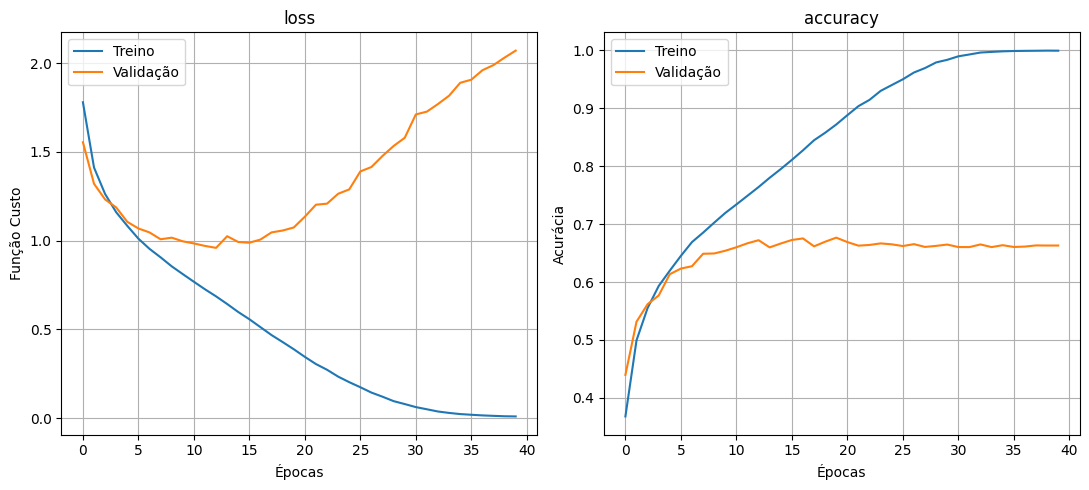

In [ ]:
plot_acc_loss(hist)

A figure is created and saved to file showing the learning curves of the model during training on the train and test dataset, both with regards to the loss and accuracy.

In this case, we can see that the model rapidly overfits the test dataset. This is clear if we look at the plot of loss (top plot), we can see that the model’s performance on the training dataset (blue) continues to improve whereas the performance on the test dataset (orange) improves, then starts to get worse at around 15 epochs.

##Analyzing loss improvement
**Figure A** shows that the network improves the loss value on the training data but fails to generalize on the validation data. Learning on the validation data progresses in the first couple of epochs and then flattens out and maybe decreases. **This is a form of overfitting**. Note that this graph shows that the network is actually learning on the training data, a good sign that training is happening. So you don’t need to add more hidden units, nor do you need to build a more complex model. If anything, your network is too complex for your data, because it is learning so
much that it is actually memorizing the data and failing to generalize to new data. In this case, your next step might be to collect more data or apply techniques to avoid overfitting.

**Figure B** shows that the network performs poorly on both training and validation
data. In this case, your network is not learning. You don’t need more data, because the
network is too simple to learn from the data you already have. Your next step is to
build a more complex model.

**Figure C** shows that the network is doing a good job of learning the training
data and generalizing to the validation data. This means there is a good chance that
the network will have good performance out in the wild on test data.

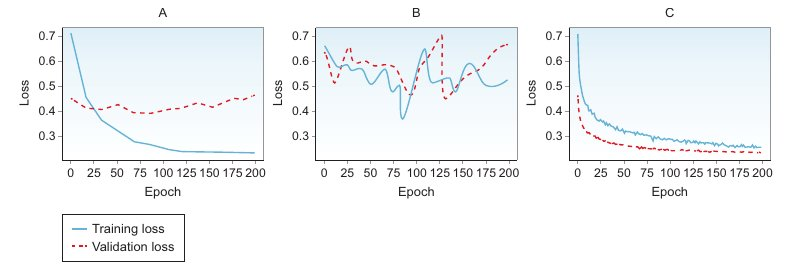

##2-block VGG style architecture

In [ ]:
K.clear_session()
model = Sequential(name='2_block_VGG')
model.add(Input((32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
# example output part of the model
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
# salva os pesos e bias com os valores inicias
initial_weights2 = model.get_weights()

In [ ]:
# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "2_block_VGG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 591,274 (2.26 MB)

 Trainable params: 591,274 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# início do treinamento da rede
start_time = time.process_time()
# carrega os pesos e bias com os valores inicias, para um novo treinamento da rede
model.set_weights(initial_weights2)
# fit model
hist = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_test, y_test), verbose=1)
# tempo total de treinamento da rede
processing_time(start_time, time.process_time())

Epoch 1/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.3019 - loss: 1.9285 - val_accuracy: 0.4609 - val_loss: 1.5005
Epoch 2/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.4858 - loss: 1.4325 - val_accuracy: 0.5450 - val_loss: 1.2791
Epoch 3/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5572 - loss: 1.2442 - val_accuracy: 0.5894 - val_loss: 1.1577
Epoch 4/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6078 - loss: 1.1112 - val_accuracy: 0.6101 - val_loss: 1.0945
Epoch 5/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6432 - loss: 1.0149 - val_accuracy: 0.6289 - val_loss: 1.0489
Epoch 6/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6713 - loss: 0.9474 - val_accuracy: 0.6663 - val_loss: 0.9615
Epoch 7/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6983 - loss: 0.8698 - val_accuracy: 0.6743 - val_loss: 0.9426
Epoch 8/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7243 - loss: 0.8070 - val_accuracy:

In [ ]:
# salvando o modelo da rede treinada (modelo, pesos e bias) e o 'history' (accuracy e loss)
save_model(model, 2, hist)

Saved model to disk


In [ ]:
# carrego o modelo e 'history' da rede treinada
model, hist = load_model(model_nr=2)

Loaded model from disk


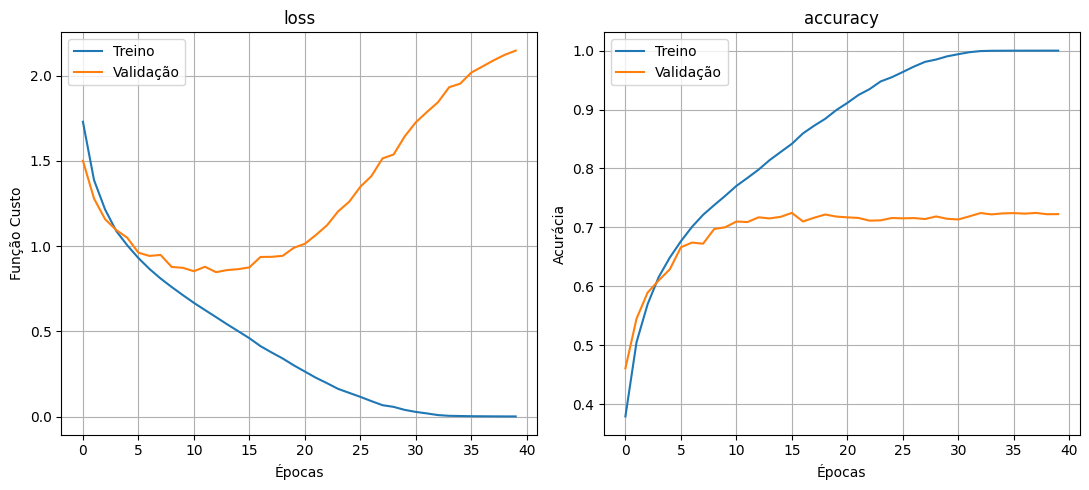

In [ ]:
plot_acc_loss(hist)

In this case, we can see that the model with two blocks performs better than the model with a single block: a good sign!

##3-block VGG style architecture

In [ ]:
K.clear_session()
model = Sequential(name='3_block_VGG')
model.add(Input((32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
initial_weights3 = model.get_weights()

In [ ]:
# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "3_block_VGG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,570 (2.10 MB)

 Trainable params: 550,570 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# início do treinamento da rede
start_time = time.process_time()
# carrega os pesos e bias com os valores inicias, para um novo treinamento da rede
model.set_weights(initial_weights3)
# fit model
hist = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_test, y_test), verbose=1)
# tempo total de treinamento da rede
processing_time(start_time, time.process_time())

Epoch 1/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.2737 - loss: 1.9997 - val_accuracy: 0.4690 - val_loss: 1.4697
Epoch 2/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4919 - loss: 1.4204 - val_accuracy: 0.5279 - val_loss: 1.3164
Epoch 3/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5650 - loss: 1.2385 - val_accuracy: 0.5826 - val_loss: 1.1681
Epoch 4/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6094 - loss: 1.1047 - val_accuracy: 0.6136 - val_loss: 1.0869
Epoch 5/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6548 - loss: 0.9898 - val_accuracy: 0.6488 - val_loss: 0.9940
Epoch 6/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6790 - loss: 0.9145 - val_accuracy: 0.6565 - val_loss: 0.9682
Epoch 7/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6991 - loss: 0.8590 - val_accuracy: 0.6757 - val_loss: 0.9314
Epoch 8/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7321 - loss: 0.7746 - val_accura

In [ ]:
# salvando o modelo da rede treinada (modelo, pesos e bias) e o 'history' (accuracy e loss)
save_model(model, 3, hist)

Saved model to disk


In [ ]:
# carrego o modelo e 'history' da rede treinada
model, hist = load_model(model_nr=3)

Loaded model from disk


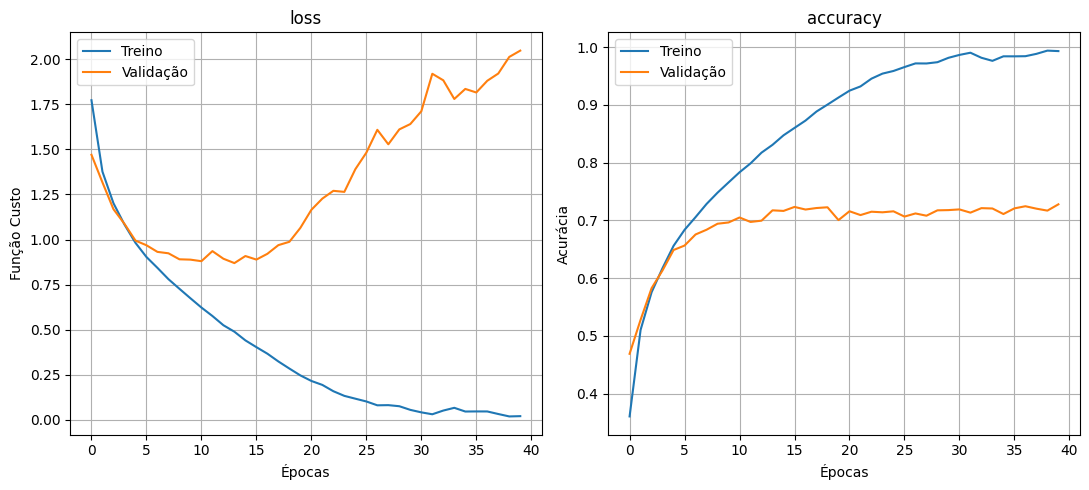

In [ ]:
plot_acc_loss(hist)

In this case, yet another modest increase in performance is seen as the depth of the model was increased. Reviewing the figures showing the learning curves, again we see dramatic overfitting within the first 20 training epochs.

##First results analyzinging
We have explored three different models with a VGG-based architecture.

The results of validation accuracy can be summarized below, although we must assume some variance in these results given the stochastic nature of the algorithm:

    VGG 1: 67.07%
    VGG 2: 71.08%
    VGG 3: 72.80%

In all cases, the model was able to learn the training dataset, showing an improvement on the training dataset that at least continued to 40 epochs, and perhaps more. This is a good sign, as it shows that the problem is learnable and that all three models have sufficient capacity to learn the problem.

The results of the model on the test dataset showed an improvement in classification accuracy with each increase in the depth of the model. It is possible that this trend would continue if models with four and five layers were evaluated, and this might make an interesting extension. Nevertheless, all three models showed the same pattern of dramatic overfitting at around 15-to-20 epochs.

These results suggest that the model with three VGG blocks is a good starting point or baseline model for our investigation.

The results also suggest that the model is in need of regularization to address the rapid overfitting of the test dataset. More generally, the results suggest that it may be useful to investigate techniques that slow down the convergence (rate of learning) of the model. This may include techniques such as data augmentation as well as learning rate schedules, changes to the batch size, and perhaps more.

In the next section, we will investigate some of these ideas for improving model performance.

##Regularization Techniques
Now that we have established a baseline model, the VGG architecture with three blocks, we can investigate modifications to the model and the training algorithm that seek to improve performance.

We will look at two main areas first to address the severe overfitting observed, namely regularization and data augmentation.

There are many regularization techniques we could try, although the nature of the overfitting observed suggests that perhaps early stopping would not be appropriate and that techniques that slow down the rate of convergence might be useful.

We will look into the effect of both **dropout** and **weight regularization** or **weight decay**

###Dropout Regularization

Dropout is a simple technique that will randomly drop nodes out of the network. It has a regularizing effect as the remaining nodes must adapt to pick-up the slack of the removed nodes.

Dropout can be added to the model by adding new Dropout layers, where the amount of nodes removed is specified as a parameter. There are many patterns for adding Dropout to a model, in terms of where in the model to add the layers and how much dropout to use.

In this case, we will add Dropout layers after each max pooling layer and after the fully connected layer, and use a fixed dropout rate of 20% (e.g. retain 80% of the nodes).

The updated VGG 3 baseline model with dropout is listed below.

##3-block VGG with Dropout

In [ ]:
K.clear_session()
model = Sequential(name='3_block_VGG_dropout')
model.add(Input((32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
initial_weights4 = model.get_weights()

In [ ]:
# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "3_block_VGG_dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,570 (2.10 MB)

 Trainable params: 550,570 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# início do treinamento da rede
start_time = time.process_time()
# carrega os pesos e bias com os valores inicias, para um novo treinamento da rede
model.set_weights(initial_weights4)
# fit model
hist = model.fit(X_train, y_train, epochs=60, batch_size=64, validation_data=(X_test, y_test), verbose=1)
# tempo total de treinamento da rede
processing_time(start_time, time.process_time())

Epoch 1/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1812 - loss: 2.1913 - val_accuracy: 0.3925 - val_loss: 1.6789
Epoch 2/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3651 - loss: 1.7252 - val_accuracy: 0.4443 - val_loss: 1.5405
Epoch 3/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4173 - loss: 1.5853 - val_accuracy: 0.4790 - val_loss: 1.4143
Epoch 4/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4568 - loss: 1.4849 - val_accuracy: 0.5040 - val_loss: 1.3753
Epoch 5/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4838 - loss: 1.4049 - val_accuracy: 0.5429 - val_loss: 1.2687
Epoch 6/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5120 - loss: 1.3440 - val_accuracy: 0.5656 - val_loss: 1.2133
Epoch 7/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5404 - loss: 1.2697 - val_accuracy: 0.5772 - val_loss: 1.1707
Epoch 8/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5609 - loss: 1.2135 - val_accura

In [ ]:
# salvando o modelo da rede treinada (modelo, pesos e bias) e o 'history' (accuracy e loss)
save_model(model, 4, hist)

Saved model to disk


In [ ]:
# carrego o modelo e 'history' da rede treinada
model, hist = load_model(model_nr=4)

Loaded model from disk


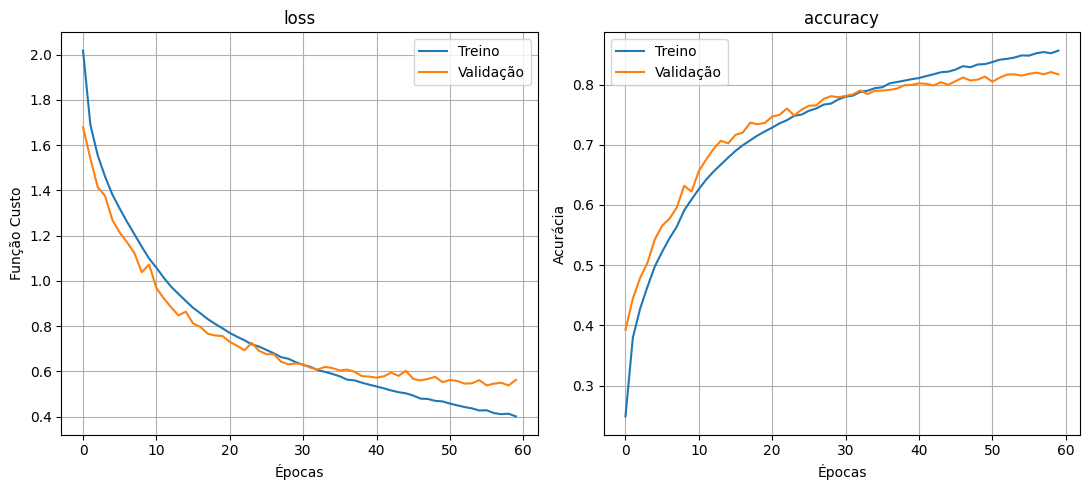

In [ ]:
plot_acc_loss(hist)

In this case, we can see a jump in validation classification accuracy by about 10% from about ~73% without dropout to about ~81% with dropout.

Reviewing the learning curve for the model, we can see that overfitting has been addressed. The model converges well for about 40 or 50 epochs, at which point there is no further improvement on the test dataset.

This is a great result. We could elaborate upon this model and add early stopping with a patience of about 10 epochs to save a well-performing model on the test set during training at around the point that no further improvements are observed. We could also try exploring a learning rate schedule that drops the learning rate after improvements on the test set stall.

Dropout has performed well, and we do not know that the chosen rate of 20% is the best. We could explore other dropout rates, as well as differing positioning of the dropout layers in the model architecture.

##Weight Decay (L2 regularization)

Weight regularization, L2 regularization or weight decay involves updating the loss function to penalize the model in proportion to the size of the model weights. L2 regularization, or the L2 norm, or Ridge (in regression problems), combats overfitting by forcing weights to be small, but not making them exactly 0.

This has a regularizing effect, as larger weights result in a more complex and less stable model, whereas smaller weights are often more stable and more general.

We can add weight regularization to the convolutional layers and the fully connected layers by defining the “kernel_regularizer” argument and specifying the type of regularization. In this case, we will use L2 weight regularization, the most common type used for neural networks and a sensible default weighting of 0.001.

The updated baseline model with weight decay is listed below.

##3-block VGG with Weight Decay (L2 regularization)

In [ ]:
K.clear_session()
model = Sequential(name='3_block_VGG_L2')
model.add(Input((32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model.add(Dense(10, activation='softmax'))
initial_weights5 = model.get_weights()

In [ ]:
# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "3_block_VGG_L2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,570 (2.10 MB)

 Trainable params: 550,570 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# início do treinamento da rede
start_time = time.process_time()
# carrega os pesos e bias com os valores inicias, para um novo treinamento da rede
model.set_weights(initial_weights5)
# fit model
hist = model.fit(X_train, y_train, epochs=45, batch_size=64, validation_data=(X_test, y_test), verbose=1)
# tempo total de treinamento da rede
processing_time(start_time, time.process_time())

Epoch 1/45
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.2931 - loss: 3.1025 - val_accuracy: 0.4588 - val_loss: 2.6246
Epoch 2/45
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4776 - loss: 2.5672 - val_accuracy: 0.5183 - val_loss: 2.4530
Epoch 3/45
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5441 - loss: 2.3657 - val_accuracy: 0.5616 - val_loss: 2.2978
Epoch 4/45
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5916 - loss: 2.2159 - val_accuracy: 0.6036 - val_loss: 2.1662
Epoch 5/45
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6349 - loss: 2.0732 - val_accuracy: 0.6325 - val_loss: 2.0526
Epoch 6/45
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6682 - loss: 1.9647 - val_accuracy: 0.6376 - val_loss: 2.0121
Epoch 7/45
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6899 - loss: 1.8726 - val_accuracy: 0.6641 - val_loss: 1.9379
Epoch 8/45
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7205 - loss: 1.7812 - val_accur

In [ ]:
# salvando o modelo da rede treinada (modelo, pesos e bias) e o 'history' (accuracy e loss)
save_model(model, 5, hist)

Saved model to disk


In [ ]:
# carrego o modelo e 'history' da rede treinada
model, hist = load_model(model_nr=5)

Loaded model from disk


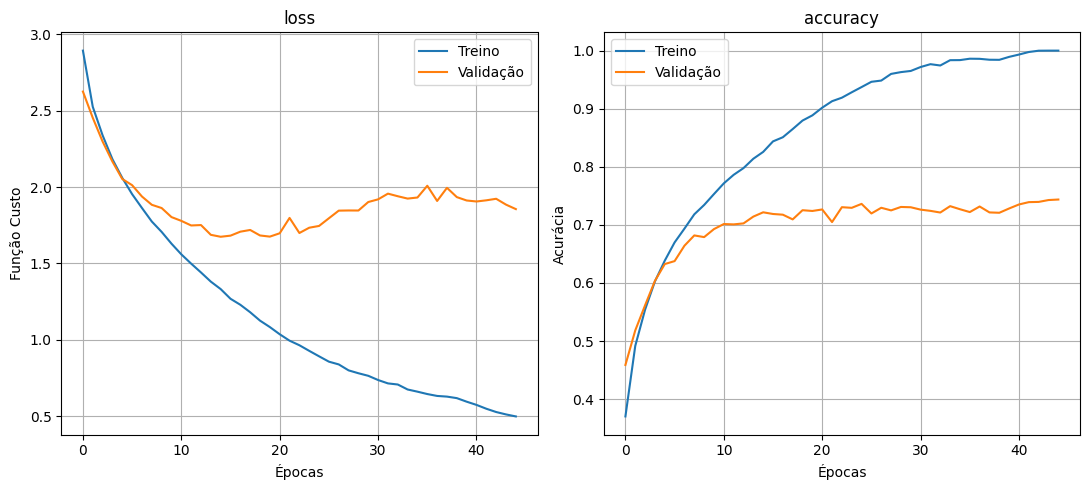

In [ ]:
plot_acc_loss(hist)

In this case, we see no improvement in the model performance on the test set; in fact, we see a small increse in performance from about 72% to about 74% at validation classification accuracy. The instability of the network is notable through variations in performance over the epochs.

Reviewing the learning curves, we do see a small reduction in the overfitting, but the impact is not as effective as dropout. We might be able to improve the effect of weight decay by perhaps using a larger weighting, such as 0.01 or even 0.1, taking care of stability.

##Data Augmentation

Data augmentation involves making copies of the examples in the training dataset with small random modifications. This has a regularizing effect as it both expands the training dataset and allows the model to learn the same general features, although in a more generalized manner.

There are many types of data augmentation that could be applied. Given that the dataset is comprised of small photos of objects, we do not want to use augmentation that distorts the images too much, so that useful features in the images can be preserved and used. The types of random augmentations that could be useful include a horizontal flip, minor shifts of the image, and perhaps small zooming or cropping of the image.

We will investigate the effect of simple augmentation on the baseline image, specifically horizontal flips and 10% shifts in the height and width of the image. This can be implemented in Keras using the [ImageDataGenerator class](https://keras.io/preprocessing/image/), for example.

<center><img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*Jujct_Pt-zvdWtSFpHUp3Q.png"></center>

##3-block VGG with Data Augmentation

In [ ]:
K.clear_session()
model = Sequential(name='3_block_VGG_Augmentation')
model.add(Input((32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
initial_weights6 = model.get_weights()

In [ ]:
# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "3_block_VGG_Augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,570 (2.10 MB)

 Trainable params: 550,570 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# create data generator
datagen = ImageDataGenerator(
  featurewise_center=False,  # set input mean to 0 over the dataset
  samplewise_center=False,  # set each sample mean to 0
  featurewise_std_normalization=False,  # divide inputs by std of the dataset
  samplewise_std_normalization=False,  # divide each input by its std
  zca_whitening=False,  # apply ZCA whitening
  rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
  width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
  height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
  horizontal_flip=True,  # randomly flip images
  vertical_flip=False  # randomly flip images
)
datagen.fit(X_train)

In [ ]:
# início do treinamento da rede
start_time = time.process_time()
# prepare iterator
it_train = datagen.flow(X_train, y_train_cat, batch_size=64)
steps = int(X_train.shape[0] / 64)
# carrega os pesos e bias com os valores inicias, para um novo treinamento da rede
model.set_weights(initial_weights6)
# fit model
hist=model.fit(it_train, epochs=50, batch_size=128, validation_data=(X_test, y_test_cat), verbose=1)
#hist=model.fit(it_train, steps_per_epoch=steps, epochs=45, validation_data=(X_test, y_test_cat), verbose=1)
# tempo total de treinamento da rede
processing_time(start_time, time.process_time())

In [ ]:
# salvando o modelo da rede treinada (modelo, pesos e bias) e o 'history' (accuracy e loss)
save_model(model, 6, hist)

Saved model to disk


In [ ]:
# carrego o modelo e 'history' da rede treinada
model, hist = load_model(model_nr=6)

Loaded model from disk


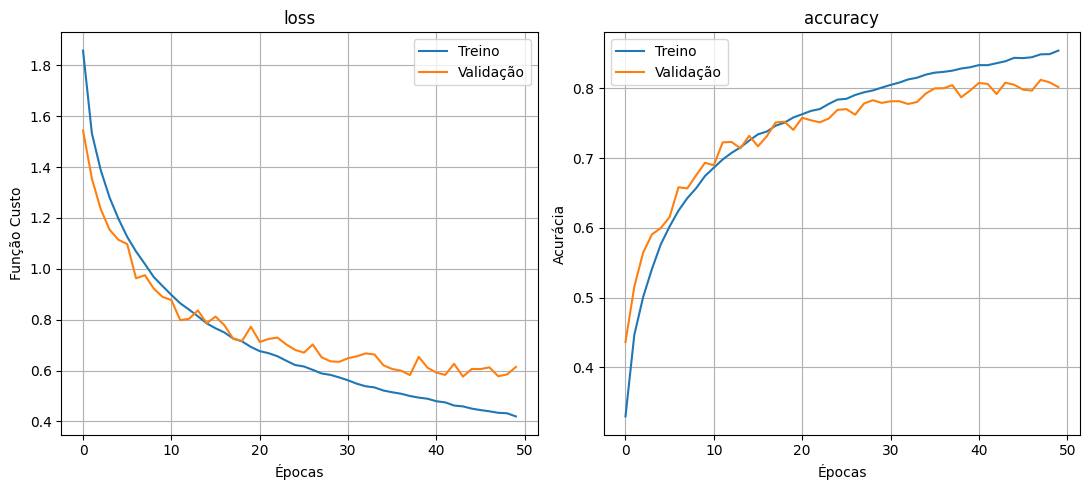

In [ ]:
plot_acc_loss(hist)

In this case, we see another large improvement in model performance, much like we saw with dropout. In this case, an improvement of about 11% from about 73% for the baseline model to about 84%.

Reviewing the learning curves, we see a similar improvement in model performances as we do with dropout, although the plot of loss suggests that model performance on the test set may have stalled slightly sooner than it did with dropout. The results suggest that perhaps a configuration that used both dropout and data augmentation might be effective.

##Regularization results analyzinging

In this section, we explored three approaches designed to slow down the convergence of the model.

A summary of the results is provided below:

    Baseline + Dropout: 83.450%
    Baseline + Weight Decay: 72.550%
    Baseline + Data Augmentation: 84.470%

The results suggest that both dropout and data augmentation are having the desired effect, and weight decay, at least for the chosen configuration, did not.

Now that the model is learning well, we can look for both improvements on what is working, as well as combinations on what is working.

In the previous section, we discovered that dropout and data augmentation, when added to the baseline model, result in a model that learns the problem well.

We will now investigate refinements of these techniques to see if we can further improve the model’s performance. Specifically, we will look at a variation of dropout regularization and combining dropout with data augmentation.

Learning has slowed down, so we will investigate increasing the number of training epochs to give the model enough space, if needed, to expose the learning dynamics in the learning curves.

##Variation of Dropout Regularization

Dropout is working very well, so it may be worth investigating variations of how dropout is applied to the model.

One variation that might be interesting is to increase the amount of dropout from 20% to 25% or 30%. Another variation that might be interesting is using a pattern of increasing dropout from 20% for the first block, 30% for the second block, and so on to 50% at the fully connected layer in the classifier part of the model.

This type of increasing dropout with the depth of the model is a common pattern. It is effective as it forces layers deep in the model to regularize more than layers closer to the input.

The baseline model with dropout updated to use a pattern of increasing dropout percentage with model depth is defined below.

##3-block VGG with Dropout incrementing

In [ ]:
K.clear_session()
model = Sequential(name='3_block_VGG_dropout_inc')
model.add(Input((32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
initial_weights7 = model.get_weights()

In [ ]:
# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "3_block_VGG_dropout_inc"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,570 (2.10 MB)

 Trainable params: 550,570 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# início do treinamento da rede
start_time = time.process_time()
# carrega os pesos e bias com os valores inicias, para um novo treinamento da rede
model.set_weights(initial_weights7)
# fit model
hist = model.fit(X_train, y_train_cat, epochs=150, batch_size=64, validation_data=(X_test, y_test_cat), verbose=1)
# tempo total de treinamento da rede
processing_time(start_time, time.process_time())

Epoch 1/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.1172 - loss: 2.3741 - val_accuracy: 0.2345 - val_loss: 2.0961
Epoch 2/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.2163 - loss: 2.0832 - val_accuracy: 0.3446 - val_loss: 1.8133
Epoch 3/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3028 - loss: 1.8465 - val_accuracy: 0.4025 - val_loss: 1.6761
Epoch 4/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3520 - loss: 1.7197 - val_accuracy: 0.4214 - val_loss: 1.5824
Epoch 5/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3983 - loss: 1.6232 - val_accuracy: 0.4662 - val_loss: 1.4579
Epoch 6/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4301 - loss: 1.5400 - val_accuracy: 0.4875 - val_loss: 1.3934
Epoch 7/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4507 - loss: 1.4914 - val_accuracy: 0.5115 - val_loss: 1.3482
Epoch 8/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4750 - loss: 1.4266 - val

In [ ]:
# salvando o modelo da rede treinada (modelo, pesos e bias) e o 'history' (accuracy e loss)
save_model(model, 7, hist)

Saved model to disk


In [ ]:
# carrego o modelo e 'history' da rede treinada
model, hist = load_model(model_nr=7)

Loaded model from disk


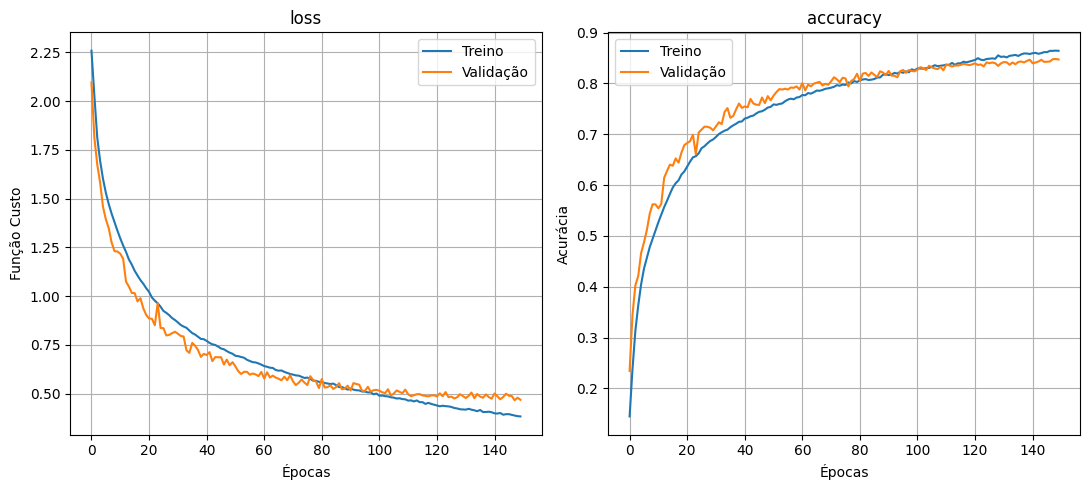

In [ ]:
plot_acc_loss(hist)

In this case, we can see a modest lift in performance from fixed dropout at about 83% to increasing dropout at about 84%.

Reviewing the learning curves, we can see that the model converges well, with performance on the test dataset perhaps stalling at around 110 to 120 epochs. Compared to the learning curves for fixed dropout, we can see that again the rate of learning has been further slowed, allowing further refinement of the model without overfitting.

This is a fruitful area for investigation on this model, and perhaps more dropout layers and/or more aggressive dropout may result in further improvements.

##Dropout and Data Augmentation

In the previous section, we discovered that both dropout and data augmentation resulted in a significant improvement in model performance.

In this section, we can experiment with combining both of these changes to the model to see if a further improvement can be achieved. Specifically, whether using both regularization techniques together results in better performance than either technique used alone.

The full code listing of a model with fixed dropout and data augmentation is provided below for completeness.

##3-block VGG with Dropout and Data Augmentation

In [ ]:
K.clear_session()
model = Sequential(name='3_block_VGG_dropout_augmentation')
model.add(Input((32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
initial_weights8 = model.get_weights()

In [ ]:
# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "3_block_VGG_dropout_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,570 (2.10 MB)

 Trainable params: 550,570 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# create data generator
datagen = ImageDataGenerator(
  featurewise_center=False,  # set input mean to 0 over the dataset
  samplewise_center=False,  # set each sample mean to 0
  featurewise_std_normalization=False,  # divide inputs by std of the dataset
  samplewise_std_normalization=False,  # divide each input by its std
  zca_whitening=False,  # apply ZCA whitening
  rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
  width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
  height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
  horizontal_flip=True,  # randomly flip images
  vertical_flip=False  # randomly flip images
)
datagen.fit(X_train)

In [ ]:
# início do treinamento da rede
start_time = time.process_time()
# carrega os pesos e bias com os valores inicias, para um novo treinamento da rede
model.set_weights(initial_weights8)
# prepare iterator
it_train = datagen.flow(X_train, y_train_cat, batch_size=64)
steps = int(X_train.shape[0] / 64)
# fit model
#hist=model.fit(it_train, steps_per_epoch=steps, epochs=30, validation_data=(X_test, y_test_cat), verbose=1)
hist=model.fit(it_train, batch_size=128, epochs=120, validation_data=(X_test, y_test_cat), verbose=1)
# tempo total de treinamento da rede
processing_time(start_time, time.process_time())

In [ ]:
# salvando o modelo da rede treinada (modelo, pesos e bias) e o 'history' (accuracy e loss)
save_model(model, 8, hist)

Saved model to disk


In [ ]:
# carrego o modelo e 'history' da rede treinada
model, hist = load_model(model_nr=8)

Loaded model from disk


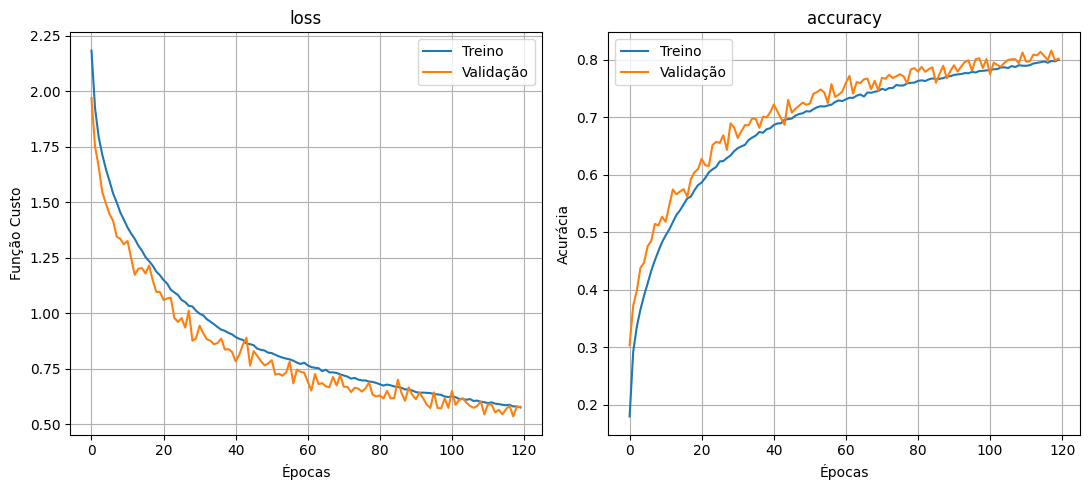

In [ ]:
plot_acc_loss(hist)

n this case, we can see that as we would have hoped, using both regularization techniques together has resulted in a further lift in model performance on the test set. In this case, combining fixed dropout with about 83% and data augmentation with about 84% has resulted in an improvement to about 85% classification accuracy.

Reviewing the learning curves, we can see that the convergence behavior of the model is also better than either fixed dropout and data augmentation alone. Learning has been slowed without overfitting, allowing continued improvement.

The plot also suggests that learning may not have stalled and may have continued to improve if allowed to continue, but perhaps very modestly.

Results might be further improved if a pattern of increasing dropout was used instead of a fixed dropout rate throughout the depth of the model.

<a name="cell-id2"></a>
##Dropout + Data Augmentation + Batch Normalization

We can expand upon the previous example in a few ways.

First, we can increase the number of training epochs to 250, to give the model more of an opportunity to improve. Best results could be found with about 400 epochs.

Next, we can add batch normalization in an effort to stabilize the learning and perhaps accelerate the learning process. To offset this acceleration, we can increase the regularization by changing the dropout from a fixed pattern to an increasing pattern.

The updated model definition is listed below.

In [ ]:
K.clear_session()
model = Sequential(name='3_block_VGG_dropout_aug_norm')
model.add(Input((32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
initial_weights9 = model.get_weights()

In [ ]:
# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "3_block_VGG_dropout_aug_norm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
# início do treinamento da rede
start_time = time.process_time()
# carrega os pesos e bias com os valores inicias, para um novo treinamento da rede
model.set_weights(initial_weights9)
# prepare iterator
#it_train = datagen.flow(X_train, y_train_cat, batch_size=64)
it_train = datagen.flow(X_train, y_train_cat, batch_size=128)
#steps = int(X_train.shape[0] / 64)
# fit model
#hist=model.fit(it_train, steps_per_epoch=steps, epochs=250, validation_data=(X_test, y_test_cat), verbose=1)
hist=model.fit(it_train, batch_size=128, epochs=250, validation_data=(X_test, y_test_cat), verbose=1)
# tempo total de treinamento da rede
processing_time(start_time, time.process_time())

In [ ]:
# salvando o modelo da rede treinada (modelo, pesos e bias) e o 'history' (accuracy e loss)
save_model(model, 9, hist)

In [ ]:
# carrego o modelo e 'history' da rede treinada
model, hist = load_model(model_nr=9)

Loaded model from disk


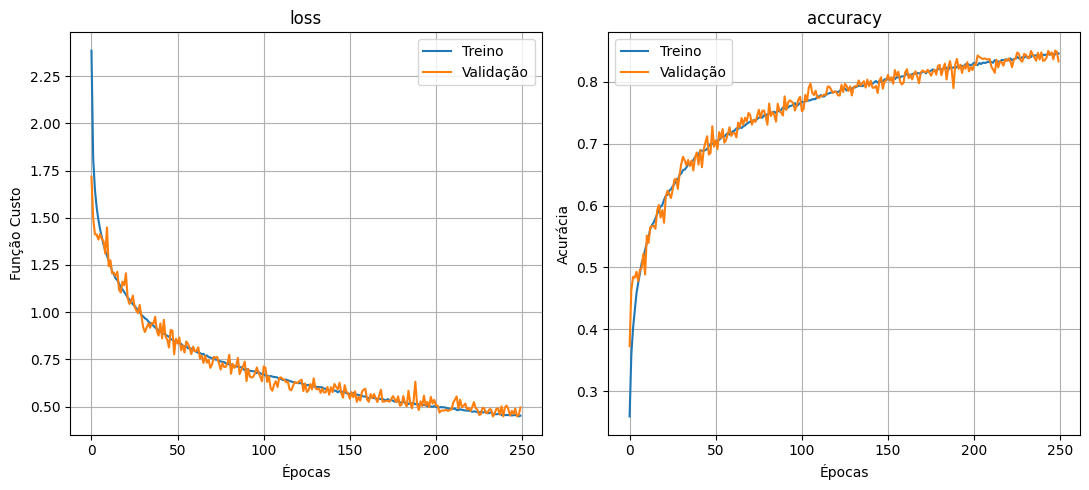

In [ ]:
plot_acc_loss(hist)

In this case, we can see that we achieved a further lift in model performance to about 87% accuracy, improving upon both dropout and data augmentation alone at about 84% and upon the increasing dropout alone at about 85%.

Reviewing the learning curves, we can see the training of the model shows continued improvement for nearly the duration of 250 epochs. We can see perhaps a slight drop-off on the test dataset at around 200 epochs, but the improvement trend does continue.

The model may benefit from further training epochs. Best results could be found with **more then 400 epochs**.

In [ ]:
K.clear_session()
model = Sequential(name='3_block_VGG_dropout_aug_norm')
model.add(Input((32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
initial_weights10 = model.get_weights()

In [ ]:
# compile model
#opt = SGD(learning_rate=0.001, momentum=0.9)
opt = RMSprop()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "3_block_VGG_dropout_aug_norm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
# início do treinamento da rede
start_time = time.process_time()
# carrega os pesos e bias com os valores inicias, para um novo treinamento da rede
model.set_weights(initial_weights10)
# prepare iterator
#it_train = datagen.flow(X_train, y_train_cat, batch_size=64)
it_train = datagen.flow(X_train, y_train_cat, batch_size=128)
#steps = int(X_train.shape[0] / 64)
# fit model
#hist=model.fit(it_train, steps_per_epoch=steps, epochs=250, validation_data=(X_test, y_test_cat), verbose=1)
hist=model.fit(it_train, batch_size=128, epochs=350, validation_data=(X_test, y_test_cat), verbose=1)
# tempo total de treinamento da rede
processing_time(start_time, time.process_time())

In [ ]:
# salvando o modelo da rede treinada (modelo, pesos e bias) e o 'history' (accuracy e loss)
save_model(model, 10, hist)

In [ ]:
# carrego o modelo e 'history' da rede treinada
model, hist = load_model(model_nr=10)

Loaded model from disk


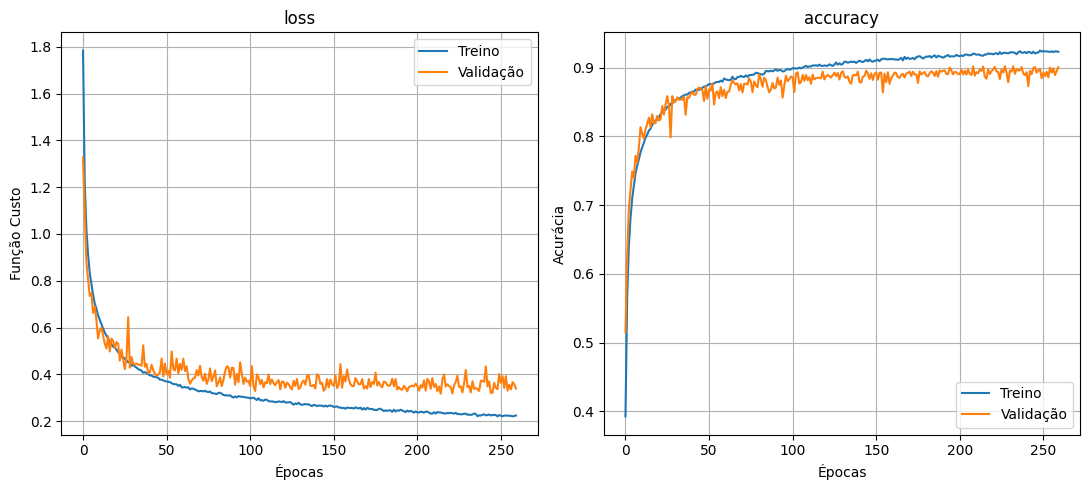

In [ ]:
plot_acc_loss(hist)

## Final discussion

In this section, we explored two approaches designed to expand upon changes to the model that we know already result in an improvement

A summary of the results is provided below:

    Baseline + Increasing Dropout: ~83%
    Baseline + Dropout + Data Augmentation: ~84%
    Baseline + Increasing Dropout + Data Augmentation + Batch Normalization: ~87%

The model is now learning well and we have good control over the rate of learning without overfitting.

We might be able to achieve further improvements with additional regularization. This could be achieved with more aggressive dropout in later layers. It is possible that further addition of weight decay may improve the model.

So far, we have not tuned the hyperparameters of the learning algorithm, such as the learning rate, which is perhaps the most important hyperparameter. We may expect further improvements with adaptive changes to the learning rate, such as use of an adaptive learning rate technique such as Adam. These types of changes may help to refine the model once converged.

##Exercícios

1. Se os modelos treinados apresentarem uma tendência de crescimento na acurácia, aumente o número de épocas de treinamento até conseguir a estabilização da acurácia. Repita este procedimento para todos modelos que apresentarem esta característica.
1.  Implementar uma arquitetura de rede com as características originais da rede VGG16, conforme a [figura](#cell-id). Efetuar o treinamento com 30, 50 e 80 épocas e comparar os resultados.
1. Incereir Dropout Regularization com 40% (dropout rate) e comparar os resultados.
1. Mudar o otimizador para Adam e depois para  RMSprop e trabalhar os hiperparâmetros da rede assim como suas sintonias de forma a tentar conseguir uma melhor performance do que apresentada no [modelo de rede 09](#cell-id2). Compare os resultados.



##Referências
[1] https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

[2] https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/

[3] https://github.com/moelgendy/deep_learning_for_vision_systems/blob/master/chapter_03/chapter_3_cifar10_cnn.ipynb

[4] Elgendy, M. *Deep Learning for Vision Systems*. Manning Publications Co. Shelter Island, NY. 2020

[5] https://www.tensorflow.org/tutorials/images/cnn?hl=en

[6] https://www.tensorflow.org/tutorials/images/classification?hl=en

##Contribuições dos alunos

Loaded model 1 from disk
313/313 [==============================] - 8s 3ms/step
Loaded model 2 from disk
313/313 [==============================] - 1s 2ms/step
Loaded model 3 from disk
313/313 [==============================] - 1s 2ms/step
Loaded model 4 from disk
313/313 [==============================] - 1s 3ms/step
Loaded model 5 from disk
313/313 [==============================] - 1s 2ms/step
Loaded model 6 from disk
313/313 [==============================] - 1s 2ms/step
Loaded model 7 from disk
313/313 [==============================] - 1s 3ms/step
Loaded model 8 from disk
313/313 [==============================] - 1s 2ms/step
Loaded model 9 from disk
313/313 [==============================] - 1s 3ms/step


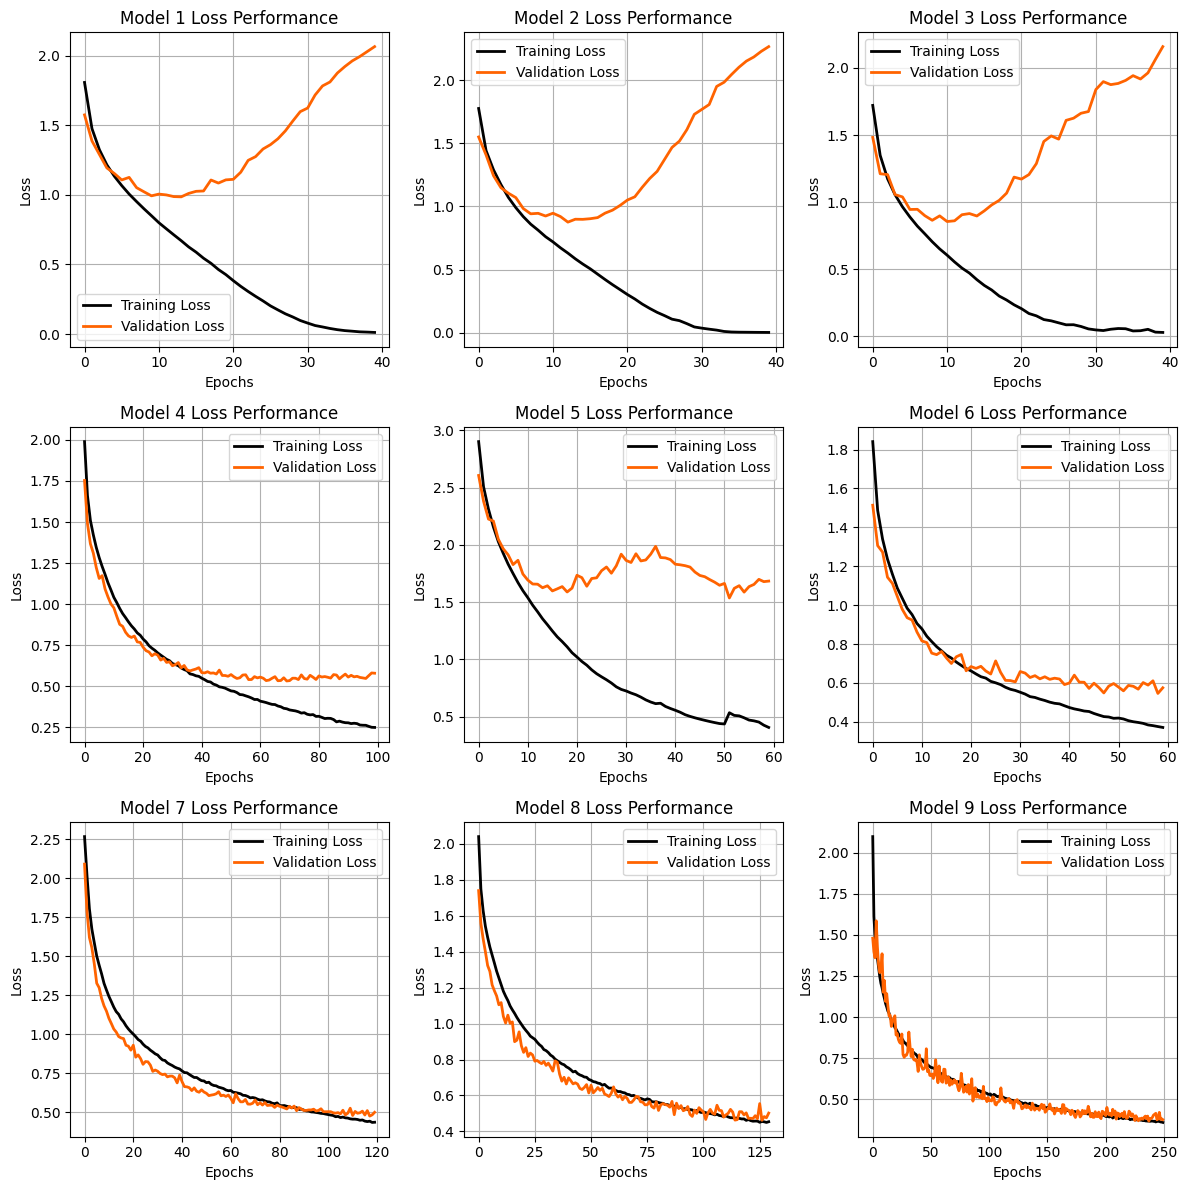

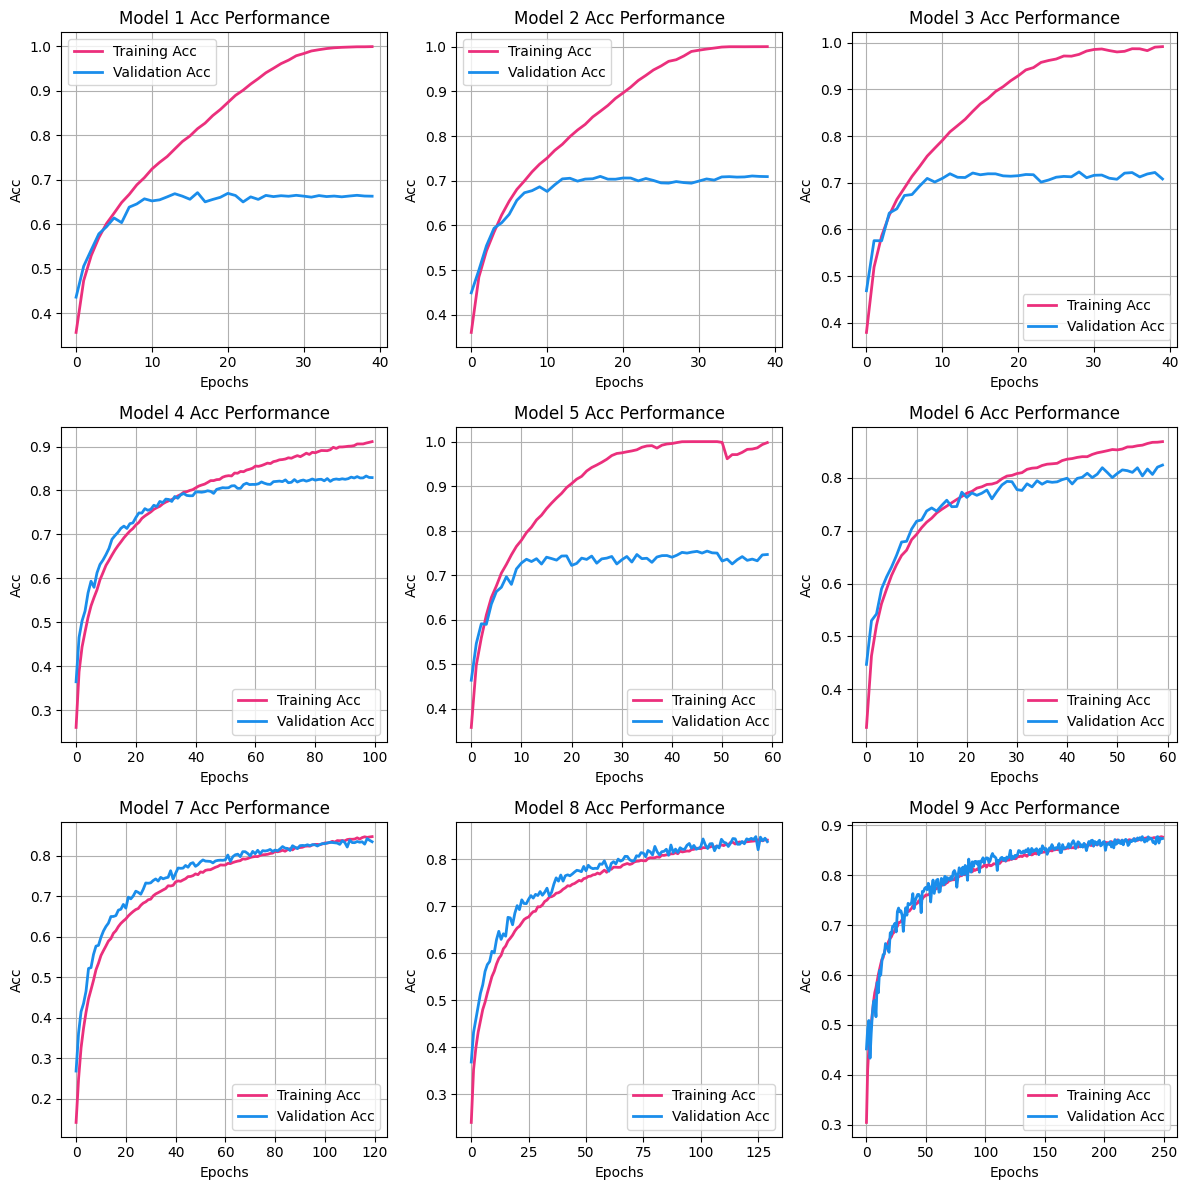

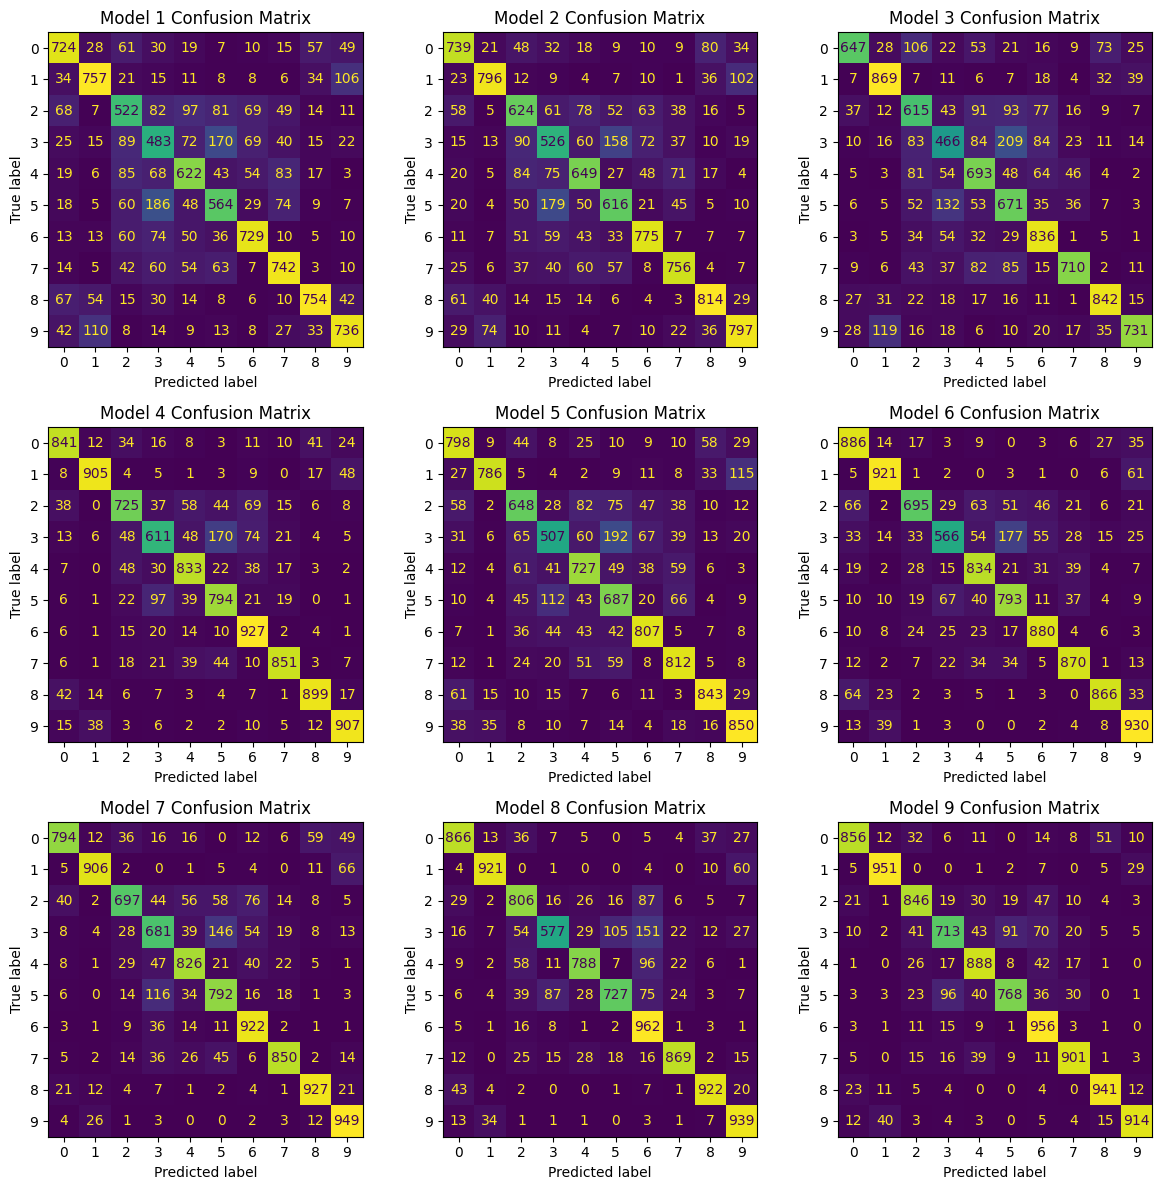

In [ ]:
# Contribuição de Gabriel Delongui Polvani <gabriel.polvani@uel.br>

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Inicialmente, vamos plotar os históricos de treinamento e analisar as curvas de aprendizado das redes treinadas:

# Função que plota todos os modelos treinados:
def models_performance(n=9):

    fig1, ax1 = plt.subplots(nrows=int(np.sqrt(n)), ncols=int(np.sqrt(n)), layout='tight', figsize=(12,12))
    ax1 = ax1.flatten() # Plots de Loss
    fig2, ax2 = plt.subplots(nrows=int(np.sqrt(n)), ncols=int(np.sqrt(n)), layout='tight', figsize=(12,12))
    ax2 = ax2.flatten() # Plots de Acurácia
    fig3, ax3 = plt.subplots(nrows=int(np.sqrt(n)), ncols=int(np.sqrt(n)), layout='tight', figsize=(12,12))
    ax3 = ax3.flatten() # Matrizes de Confusão

    # Percorre todos os modelos salvos:
    for i, m in enumerate(range(1, n+1)):
        # Load json and create model
        j_file = open('/content/drive/MyDrive/Colab Notebooks/temp/modelCNN'+str(m)+'.json','r')
        load_model_json = j_file.read()
        j_file.close()
        loaded_model=model_from_json(load_model_json)
        # Load weights into new model
        loaded_model.load_weights('/content/drive/MyDrive/Colab Notebooks/temp/weightsCNN'+str(m)+'.h5')
        print('Loaded model '+str(m)+' from disk')
        # carrego o 'history' que contem os vetores accuracy e loss para imprimir os gráficos novamente sem precisar treinar a rede
        H=np.load('/content/drive/MyDrive/Colab Notebooks/temp/history'+str(m)+'.npy',allow_pickle='TRUE').item()

        ax1[i].plot(H.history['loss'], color='#000000', label='Training Loss', lw=2)
        ax1[i].plot(H.history['val_loss'], color='#FF6300', label='Validation Loss', lw=2)
        ax1[i].set_title('Model ' + str(m) + ' Loss Performance')
        ax1[i].grid()
        ax1[i].set_xlabel('Epochs')
        ax1[i].set_ylabel('Loss')
        ax1[i].legend()

        ax2[i].plot(H.history['accuracy'], color='#EB2F7C', label='Training Acc', lw=2)
        ax2[i].plot(H.history['val_accuracy'], color='#1A8DEB', label='Validation Acc', lw=2)
        ax2[i].set_title('Model ' + str(m) + ' Acc Performance')
        ax2[i].grid()
        ax2[i].set_xlabel('Epochs')
        ax2[i].set_ylabel('Acc')
        ax2[i].legend()

        y_pred = loaded_model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        cmatrix = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cmatrix,).plot(ax=ax3[i], colorbar=False)
        ax3[i].set_title('Model ' + str(i+1) + ' Confusion Matrix')

    plt.show()

models_performance()